## Create a simple model to detect bad clients

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_clients = pd.read_csv('./application_record.csv')
df_clients.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
df_credit = pd.read_csv('./credit_record.csv')
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


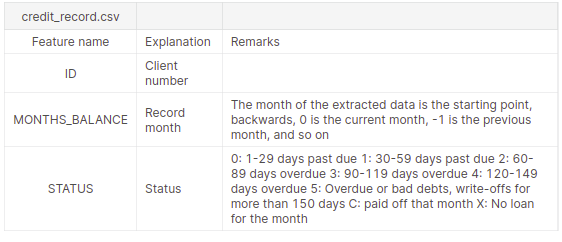

    As it's just a simple exercise, let's say that a good client is that one that don't overdue or have bad debts (C and X) more than 10% of months 

In [9]:
df_credit.head(25)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [4]:
df_bad_rate = (
 df_credit
 .assign(bad_month = lambda d: d['STATUS'].isin(['1','2','3', '4', '5']))
 .groupby("ID")
 .agg(bad_rate = ('bad_month','mean'))
 .reset_index()
 .assign(bad_client = lambda d: d['bad_rate'] > .1)
)

df_bad_rate.head()

,ID,bad_rate,bad_client
0,5001711,0.0,False
1,5001712,0.0,False
2,5001713,0.0,False
3,5001714,0.0,False
4,5001715,0.0,False


In [5]:
df_bad_rate.value_counts('bad_client')

bad_client
False    43909
True      2076
dtype: int64

In [6]:
model_variables = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE',
                  'NAME_FAMILY_STATUS', 'AGE', 'bad_client']

df_model = (
 df_clients
 .merge(df_bad_rate, how='left')
 .query('not bad_client.isna()', engine='python')
 .assign(AGE = lambda d: [int(round((-1*x)/365)) for x in d['DAYS_BIRTH']])
 [model_variables]
)

In [46]:
df_model.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,AGE,bad_client
0,M,Y,Y,427500.0,Higher education,Civil marriage,33,False
1,M,Y,Y,427500.0,Higher education,Civil marriage,33,False
2,M,Y,Y,112500.0,Secondary / secondary special,Married,59,False
3,F,N,Y,270000.0,Secondary / secondary special,Single / not married,52,False
4,F,N,Y,270000.0,Secondary / secondary special,Single / not married,52,False


In [128]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [84]:
model = GradientBoostingClassifier()

In [155]:
X = df_model.loc[:, df_model.columns != 'bad_client']
Y = df_model.bad_client.astype('int')

In [156]:
categorical_feature_mask = X.dtypes==object

In [157]:
categorical_feature_names = categorical_feature_mask[categorical_feature_mask].index

In [158]:
encoder = ColumnTransformer([('', OneHotEncoder(), categorical_feature_names)], remainder='passthrough')
encoder.fit(X)
X = encoder.transform(X) #one hot encoding

In [159]:
encoder.get_feature_names()

['__x0_N',
 '__x0_Y',
 '__x1_N',
 '__x1_Y',
 '__x2_Academic degree',
 '__x2_Higher education',
 '__x2_Incomplete higher',
 '__x2_Lower secondary',
 '__x2_Secondary / secondary special',
 '__x3_Civil marriage',
 '__x3_Married',
 '__x3_Separated',
 '__x3_Single / not married',
 '__x3_Widow',
 'AMT_INCOME_TOTAL',
 'AGE']

In [160]:
model.fit(X, Y)

GradientBoostingClassifier()

In [147]:
feature_names = X.columns
labels = Y.astype('str')

AttributeError: columns not found

In [163]:
model.feature_importances_

array([0.03675145, 0.01309118, 0.01587184, 0.02146485, 0.00144221,
       0.0357264 , 0.05425059, 0.00270907, 0.00930333, 0.0190471 ,
       0.01842456, 0.05689133, 0.02851627, 0.01019817, 0.41118071,
       0.26513094])

In [185]:
import joblib
joblib.dump(encoder, 'OneHotencoder.joblib') # save the model
joblib.dump(model, 'xgb_model.joblib') # save the model
#clf = load('filename.joblib') # load and reuse the model

['xgb_model.joblib']

In [183]:
class CreditModel():
    
    def __init__(self):
        self.model = joblib.load('xgb_model.joblib')
        self.encoder = joblib.load('OneHotencoder.joblib')
    
    def predict(self, FLAG_OWN_CAR, FLAG_OWN_REALTY, AMT_INCOME_TOTAL,
                NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, AGE):
        data_dict = {'FLAG_OWN_CAR':FLAG_OWN_CAR,
                     'FLAG_OWN_REALTY':FLAG_OWN_REALTY,
                     'AMT_INCOME_TOTAL':AMT_INCOME_TOTAL,
                     'NAME_EDUCATION_TYPE': NAME_EDUCATION_TYPE,
                     'NAME_FAMILY_STATUS': NAME_FAMILY_STATUS,
                     'AGE':AGE}
        df_pred = pd.DataFrame([data_dict])
        X_pred = self.encoder.transform(df_pred)
        credit_score = (self.model.predict_proba(X_pred)[0][0])*100
        return credit_score

In [186]:
credit = CreditModel()

In [194]:
credit.predict(FLAG_OWN_CAR='Y', FLAG_OWN_REALTY='Y',
 AMT_INCOME_TOTAL=8000, NAME_EDUCATION_TYPE= 'Lower secondary',
 NAME_FAMILY_STATUS='Single / not married', AGE=25)

49.90557425285023